In [1]:
import pandas as pd
import mplfinance as mpf
import rbot


In [3]:
bb = rbot.DummyBb()
bb.log_load(100)
ohlcv = bb.ohlcv(0, bb.log_end_ms, 60*60 * 2)
ohlcv_df = rbot.array_to_df(ohlcv)
ohlcv_df


,open,high,low,close,volume
timestamp,,,,,
2022-03-20 00:00:00+00:00,42215.0,42285.5,41800.0,41974.5,103775524.0
2022-03-20 02:00:00+00:00,41974.0,42050.0,41788.0,41940.0,62268670.0
2022-03-20 04:00:00+00:00,41940.5,41985.0,41766.5,41916.0,38393301.0
2022-03-20 06:00:00+00:00,41915.5,42020.0,41757.5,41859.5,94436560.0
2022-03-20 08:00:00+00:00,41859.5,41947.5,41588.5,41777.0,85057840.0
...,...,...,...,...,...
2022-06-27 14:00:00+00:00,20712.5,20827.0,20564.5,20730.0,145672751.0
2022-06-27 16:00:00+00:00,20727.0,20775.5,20632.0,20695.0,38109346.0
2022-06-27 18:00:00+00:00,20695.0,20918.5,20463.0,20825.0,152334272.0


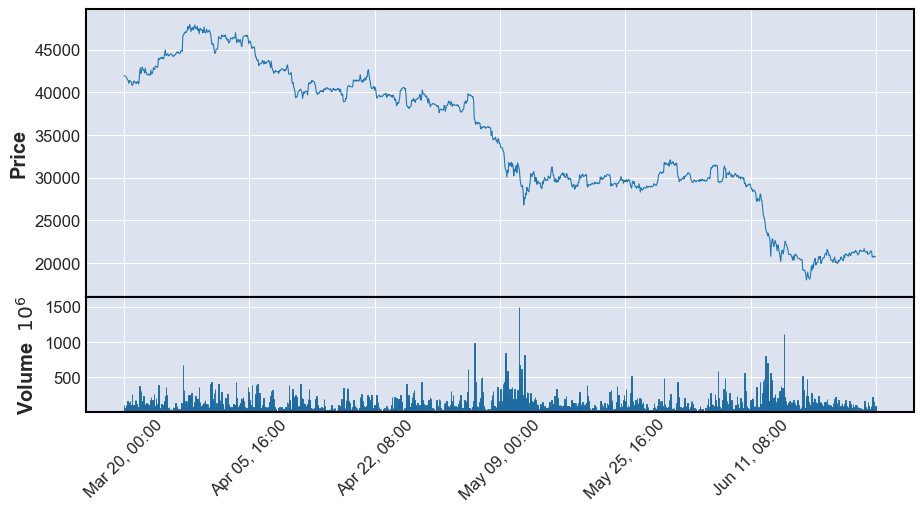

In [5]:
mpf.plot(ohlcv_df, type='line', volume=True, figratio=(16,8))

In [6]:
class Agent:
    def __init__(self, param_K=1.6):
        self.K = param_K                           # パラメターKを設定する。

    def on_clock(self, time_ms: int, session):
        ohlcv_array = session.ohlcv(60*60*2, 6)     # 最新足０番目　＋　５本の足を取得。 最新は６番目。
        ohlcv_df = rbot.array_to_df(ohlcv_array)         # ndarrayをDataFrameへ変換

        if len(ohlcv_df.index) < 6:                 # データが過去６本分そろっていない場合はなにもせずリターン
            return 

        ohlcv_df["range"] = ohlcv_df["high"] - ohlcv_df["low"]      # レンジを計算

        ohlcv_latest = ohlcv_df[-2:-1]     # 最新足１本
        ohlcv_last_5 = ohlcv_df[:-2]       # 過去５本足

        range_width = ohlcv_last_5["range"].mean()      #　過去５本足のレンジの平均値

        # Long/Short判定
        detect_short = range_width * self.K < ohlcv_latest["high"][0] - ohlcv_latest["open"][0]
        detect_long  = range_width * self.K < ohlcv_latest["open"][0] - ohlcv_latest["low"][0]

        #　執行方法（順報告のポジションがあったら保留。逆方向のポジションがのこっていたらドテン）
        if detect_long:
            if not session.long_pos_size:
                if not session.short_pos_size:
                    return rbot.Order("Buy", session.buy_edge_price, 10, 600, "Open Long")    
                else:
                    return rbot.Order("Buy", session.buy_edge_price, 20, 600, "doten Long")    
            else:
                pass

        if detect_short:
            if not session.short_pos_size:
                if not session.long_pos_size:
                    return rbot.Order("Sell", session.sell_edge_price, 10, 600, "Open Short") 
                else:
                    return rbot.Order("Sell", session.sell_edge_price, 20, 600, "Doten Short") 
            else:
                pass
  


In [7]:
agent = Agent()
result = bb.run(agent, 60*60*2)

df = rbot.result_to_df(result)

call back tick by 7200[sec]
Order! <rbot.Order object at 0x12bbd3300>
ORDER: Buy 40941 600000
Order! <rbot.Order object at 0x12bbd3120>
ORDER: Sell 42870 600000
Order! <rbot.Order object at 0x12bbd34e0>
ORDER: Buy 47435 600000
Order! <rbot.Order object at 0x12bbd3210>
ORDER: Sell 46445 600000
Order! <rbot.Order object at 0x12bbd3030>
ORDER: Buy 45813.5 600000
Order! <rbot.Order object at 0x12bbd3260>
ORDER: Sell 46455.5 600000
Order! <rbot.Order object at 0x12bbd30d0>
ORDER: Buy 46276 600000
Order! <rbot.Order object at 0x12bbd3080>
ORDER: Sell 45744.5 600000
Order! <rbot.Order object at 0x12bbd33f0>
ORDER: Buy 45936 600000
Order! <rbot.Order object at 0x12bbd35d0>
ORDER: Sell 42991 600000
Order! <rbot.Order object at 0x12bbd3710>
ORDER: Buy 42137.5 600000
Order! <rbot.Order object at 0x12bbd32b0>
ORDER: Sell 41140.5 600000
Order! <rbot.Order object at 0x12bbd3800>
ORDER: Buy 39947.5 600000
Order! <rbot.Order object at 0x12bbd3850>
ORDER: Sell 40417.5 600000
Order! <rbot.Order object a

In [33]:
df = rbot.result_to_df(result)
df = df.set_index("create_time", drop=True)

In [47]:
chart = pd.merge_asof(ohlcv_df, df, left_on="timestamp", right_on="timestamp", direction="nearest")


In [50]:

ap2 = [
    mpf.make_addplot(chart['sum_profit'], type='line', color='g', panel=2),
    mpf.make_addplot(chart['sum_pos'], type='line', color='r', panel=3)    
]

SyntaxError: invalid syntax (3738983004.py, line 3)

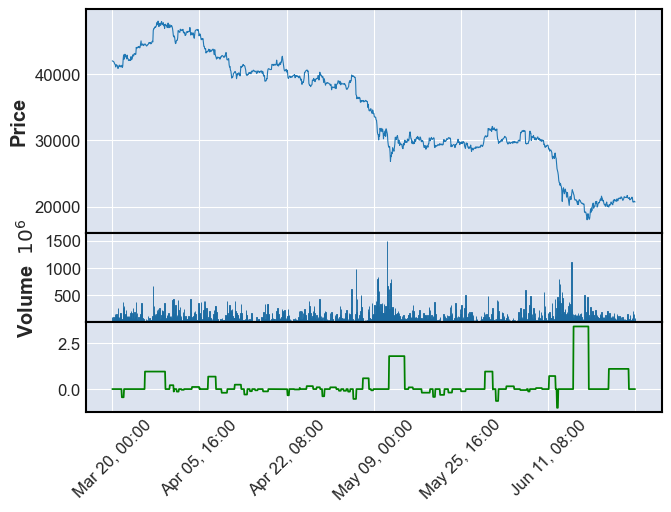

In [51]:
mpf.plot(ohlcv_df, volume=True, type='line', addplot=ap2)

In [17]:
# This allows multiple outputs from a single jupyter notebook cell:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
#%matplotlib inline
import pandas as pd

In [37]:


ap2 = [mpf.make_addplot(df['sum_profit'], type='line', color='g', panel=1)]

In [34]:
df['total_profit']

create_time
2022-03-21 05:59:59+00:00   -0.006000
2022-03-22 05:59:59+00:00   -0.455965
2022-03-22 05:59:59+00:00   -0.006000
2022-03-30 03:59:57+00:00    0.956370
2022-03-30 03:59:57+00:00   -0.006000
                               ...   
2022-06-13 03:59:57+00:00   -0.006000
2022-06-18 23:59:59+00:00    3.433274
2022-06-18 23:59:59+00:00   -0.006000
2022-06-26 15:59:59+00:00    1.103573
2022-06-26 15:59:59+00:00   -0.006000
Name: total_profit, Length: 102, dtype: float64

ValueError: x and y must have same first dimension, but have shapes (1200,) and (102,)

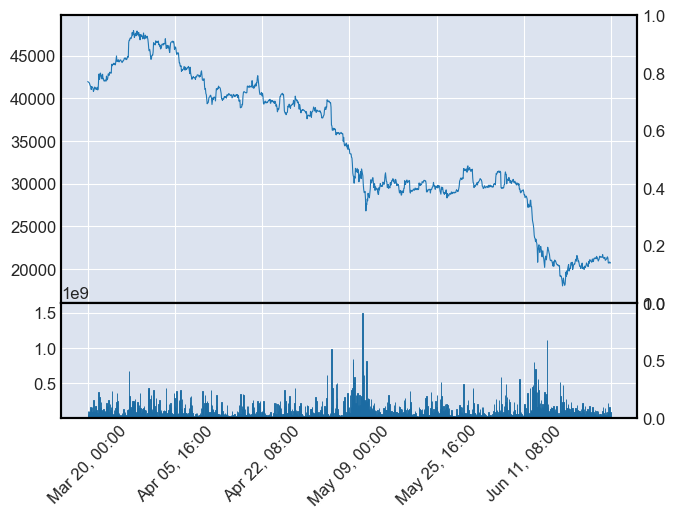

In [38]:
mpf.plot(ohlcv_df, volume=True, type='line', addplot=ap2)

/usr/local/lib/python3.9/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


ValueError: x and y must have same first dimension, but have shapes (1200,) and (102,)

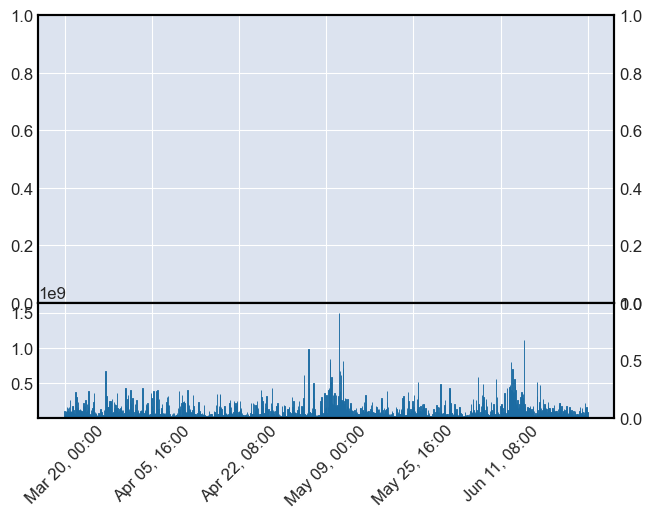

In [22]:
mpf.plot(ohlcv_df, volume=True, addplot=ap2)